Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
sys.path.insert(1,'/home/wsubuntu/GitHub/keyhandshapediscovery')
import helperFuncs as funcH
import pandas as pd

EXPERIMENT_ID = 5
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'sum','batchmean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [2]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [3]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [4]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": '/media/wsubuntu/SSD_Data/DataPath',
    "experiment": '/media/wsubuntu/SSD_Data/vaesae_experiments/sparse_torch_ae_ws_' + str(EXPERIMENT_ID).zfill(3),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.05
    bottleneck = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bottleneck)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bottleneck, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [13]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  5
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - cre tensor(2.7530, grad_fn=<AddBackward0>)
sp_loss: 2.753045082092285

       acc     bmx  bmn      mse       spr      run
0  17.538  26.152  0.0  142.364  4595.395  146.959
ValEpoch(000) - 
      acc     bmx  bmn     run
0  19.12  26.807  0.0  18.057
*****
 Epoch 1 of 100
TrEpoch(001) - 
       acc     bmx  bmn     mse       spr      run
0  18.963  35.907  0.0  95.727  4585.125  100.312
ValEpoch(001) - 
      acc     bmx  bmn     run
0  18.45  34.873  0.0  14.227
*****
 Epoch 2 of 100
TrEpoch(002) - 
       acc    bmx  bmn     mse      spr     run
0  15.267  37.08  0.0  80.777  4637.44  85.414
ValEpoch(002) - 
      acc    bmx  bmn     run
0  14.45  35.92  0.0  12.986
*****
 Epoch 3 of 100
TrEpoch(003) - 
       acc     bmx  bmn     mse       spr     run
0  19.862  37.316  0.0  74.92

ValEpoch(035) - 
      acc     bmx  bmn    run
0  20.14  26.724  0.0  7.014
*****
 Epoch 36 of 100
TrEpoch(036) - cre tensor(2.4948, grad_fn=<AddBackward0>)
sp_loss: 2.4948062896728516

      acc     bmx  bmn   mse       spr     run
0  20.02  27.431  0.0  41.4  4675.802  46.076
ValEpoch(036) - 
      acc     bmx  bmn    run
0  20.15  26.448  0.0  6.972
*****
 Epoch 37 of 100
TrEpoch(037) - 
       acc     bmx  bmn     mse       spr     run
0  20.098  26.761  0.0  41.168  4677.965  45.846
ValEpoch(037) - 
      acc     bmx  bmn    run
0  20.16  25.988  0.0  6.931
*****
 Epoch 38 of 100
TrEpoch(038) - 
       acc    bmx  bmn     mse       spr     run
0  19.995  26.66  0.0  40.947  4679.531  45.626
ValEpoch(038) - 
      acc     bmx  bmn    run
0  20.17  25.941  0.0  6.878
*****
 Epoch 39 of 100
TrEpoch(039) - 
       acc     bmx  bmn     mse       spr     run
0  20.045  26.134  0.0  40.722  4682.074  45.404
ValEpoch(039) - 
      acc     bmx  bmn    run
0  20.29  25.774  0.0  6.857
*****

ValEpoch(071) - 
      acc     bmx  bmn    run
0  22.48  21.314  0.0  6.139
*****
 Epoch 72 of 100
TrEpoch(072) - 
       acc     bmx  bmn     mse       spr     run
0  22.852  20.933  0.0  36.047  4675.402  40.723
ValEpoch(072) - 
      acc     bmx  bmn    run
0  22.65  21.057  0.0  6.124
*****
 Epoch 73 of 100
TrEpoch(073) - 
       acc     bmx  bmn     mse       spr     run
0  20.358  20.751  0.0  35.992  4674.749  40.667
ValEpoch(073) - 
      acc     bmx  bmn    run
0  22.66  20.991  0.0  6.137
*****
 Epoch 74 of 100
TrEpoch(074) - 
       acc     bmx  bmn     mse      spr     run
0  22.975  20.678  0.0  35.947  4674.07  40.621
ValEpoch(074) - 
      acc     bmx  bmn    run
0  23.11  20.921  0.0  6.113
*****
 Epoch 75 of 100
TrEpoch(075) - 
       acc     bmx  bmn     mse      spr     run
0  20.357  20.393  0.0  35.899  4673.74  40.573
ValEpoch(075) - 
      acc     bmx  bmn    run
0  22.37  20.892  0.0  6.115
*****
 Epoch 76 of 100
TrEpoch(076) - cre tensor(2.4981, grad_fn=<AddBac

In [14]:
print(result_df_tr_all)

       acc     bmx  bmn      mse       spr      run
0   17.538  26.152  0.0  142.364  4595.395  146.959
1   18.963  35.907  0.0   95.727  4585.125  100.312
2   15.267  37.080  0.0   80.777  4637.440   85.414
3   19.862  37.316  0.0   74.921  4643.357   79.565
4   19.852  38.470  0.0   71.099  4639.662   75.739
5   19.850  38.875  0.0   66.275  4636.700   70.911
6   19.860  38.570  0.0   62.430  4639.709   67.070
7   19.862  37.880  0.0   59.851  4641.091   64.492
8   19.868  37.049  0.0   57.693  4646.872   62.340
9   19.857  37.602  0.0   54.750  4652.352   59.403
10  19.862  36.945  0.0   53.079  4657.411   57.736
11  19.873  36.493  0.0   52.512  4664.899   57.177
12  19.850  35.665  0.0   51.906  4669.079   56.575
13  19.878  35.436  0.0   51.030  4669.900   55.700
14  19.855  34.749  0.0   50.656  4669.034   55.325
15  19.855  34.003  0.0   49.511  4667.752   54.179
16  19.922  33.622  0.0   48.554  4666.920   53.221
17  19.842  33.093  0.0   48.145  4664.778   52.810
18  19.875  

In [15]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   19.12  26.807  0.0  18.057
1   18.45  34.873  0.0  14.227
2   14.45  35.920  0.0  12.986
3   14.17  35.987  0.0  12.265
4   18.50  36.902  0.0  11.578
5   18.38  37.174  0.0  10.698
6   18.44  36.607  0.0  10.202
7   18.19  36.011  0.0   9.832
8   17.93  35.978  0.0   9.518
9   19.82  35.320  0.0   8.973
10  19.83  35.144  0.0   8.841
11  19.83  34.275  0.0   8.784
12  19.85  33.597  0.0   8.624
13  19.84  32.844  0.0   8.548
14  19.83  32.601  0.0   8.396
15  19.84  32.337  0.0   8.286
16  19.83  32.099  0.0   8.115
17  19.81  31.678  0.0   8.078
18  19.79  31.490  0.0   7.923
19  19.91  30.857  0.0   7.871
20  19.93  31.001  0.0   7.809
21  19.93  30.436  0.0   7.796
22  19.95  30.444  0.0   7.739
23  19.99  29.891  0.0   7.681
24  19.98  29.731  0.0   7.632
25  20.04  29.132  0.0   7.581
26  20.03  28.970  0.0   7.558
27  20.04  28.781  0.0   7.506
28  20.10  28.217  0.0   7.474
29  20.09  27.928  0.0   7.443
30  19.99  27.794  0.0   7.297
31  20.0

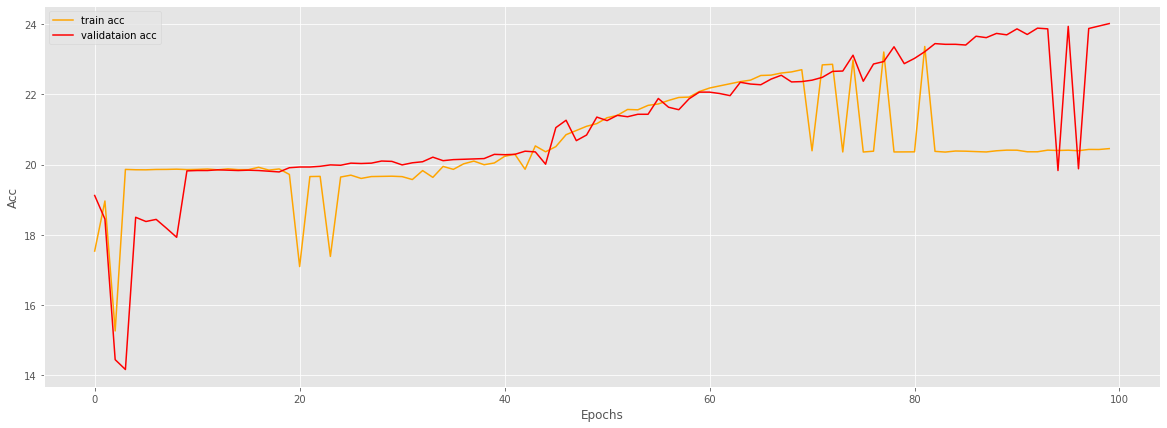

Max tr acc =  23.358333333333334
Max va acc =  24.01


In [16]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

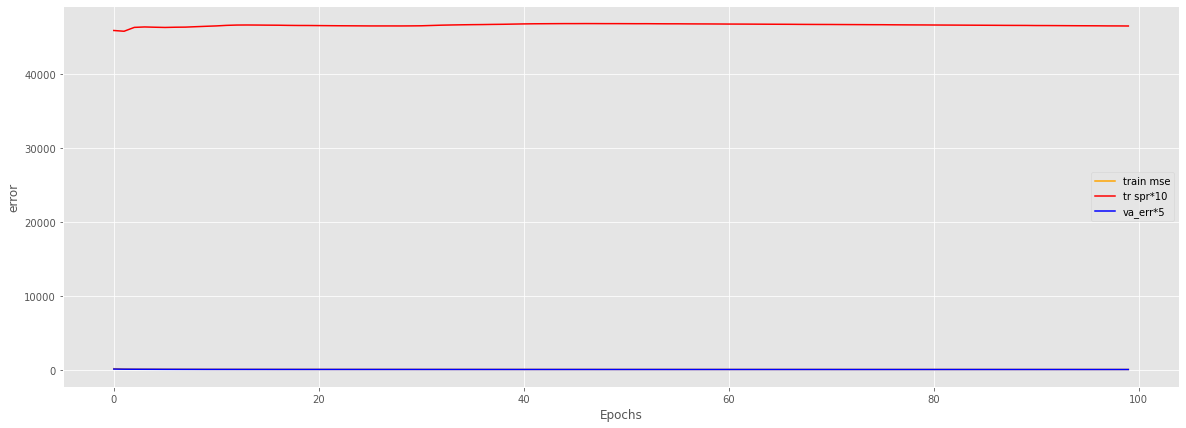

In [18]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 10*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*10')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()